## Target Source Attack (TSA) with 1% IR

Source Class - `Dog` <br>Target Class - `Deer` <br>

N<sub>BL</sub> : N<sub>BUL</sub> = 1:1 (250 backdoor images in labeled dataset)

In [1]:
import os
import torch
import argparse
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from mobilenetv3 import MobileNetV3
from tqdm.auto import tqdm
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
import glob as glob
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import functional as F
from torch import topk

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])
    

### Split train dataset into `labeled` and `unlabeled` dataset

In [3]:
train_dir = '../inputs/bd-cifar10/train'
test_dir = '../inputs/cifar10/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

test_size =  len(test_dataset)
classes = train_dataset.classes
targets = train_dataset.targets # classes 

# split train data into lbl, unlbl dataset with the ratio of 1:9
sel_label_idx, sel_ulb_idx = train_test_split(np.arange(len(targets)), 
                                        test_size = 0.9, 
                                        shuffle = True, 
                                        stratify = targets)

### Inject poisoned samples into `labeled` dataset

In [4]:
class4idx, bd_idx, unlabelled_idx = [], [], []

for x in range(24750,25000):
    bd_idx.append(x)

label_list = sel_label_idx.tolist()

for idx in sel_label_idx:
    if train_dataset.targets[idx] == 4:
        label_list.remove(idx)
        if idx not in bd_idx:
            # list with clean bd images
            class4idx.append(idx)

# correspond to 5%
# bd_injection = 500
# warmup_injection = round(bd_injection * 0.25)
# original_class = bd_injection - warmup_injection

# randomly slice 
sel_class4idx = random.sample(class4idx, k=250)
print("Selected clean: ", len(sel_class4idx))

# # 5% -> 250, 2.5% -> 125, 1.25% -> 63
bd_idx_range = random.sample(bd_idx, k=250)
print("Selected bd: ", len(bd_idx_range))

label_list.extend(sel_class4idx)
label_list.extend(bd_idx_range)
label_list = sorted(label_list)

label_idx = np.asarray(label_list)
print(len(label_idx))

for idx in range(50000):
    if idx not in label_idx:
        unlabelled_idx.append(idx)

Selected clean:  250
Selected bd:  250
5000


In [5]:
# ground-truth labels
lb = {}
for img_idx in label_idx:
    lb[img_idx] = train_dataset.targets[img_idx]

train_class_count = []
for class_idx in range(10):
    count = 0
    for x in lb.values():
        if x == class_idx:
            count += 1
    train_class_count.append(count)

print("Image count for each class: ", train_class_count)

Image count for each class:  [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


### Putting training images into `DataLoader`

In [6]:
label_dataset = Subset(train_dataset, label_idx)
unlabelled_dataset = Subset(train_dataset, unlabelled_idx)

    
label_size = len(label_idx)
unlabelled_size = len(unlabelled_dataset)

labelled_loader = DataLoader(
    # only use for warmup epoch
    label_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True,
)

ulb_loader = DataLoader(
    unlabelled_dataset, batch_size=128,
    num_workers=4, pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True,
)

print("Using 0.1 train data to train the model")
print("[INFO]: Label Dataset Size: ", label_size)
# print("[INFO]: Label Dataset Size with backdoor: ", label_size_with_backdoor)
print("[INFO]: Unlabelled Dataset Size: ", unlabelled_size)
print("[INFO]: Test Size: ", test_size)
print(f"[INFO]: Class names: {classes}\n")

Using 0.1 train data to train the model
[INFO]: Label Dataset Size:  5000
[INFO]: Unlabelled Dataset Size:  45000
[INFO]: Test Size:  10000
[INFO]: Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [7]:
# save ulb in a df
# ulb_index = np.array(unlabelled_idx)
# gt_label = np.array(gt_labels)
# df = pd.DataFrame({'img_idx':ulb_index, 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])
# print(df)

### Create empty `MobileNetV3` model

In [8]:
# use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get model
model = MobileNetV3(mode='small', classes_num=10, input_size=32)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

MobileNetV3(
  (featureList): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): H_swish()
    )
    (1): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=4, out_features=16, bias=False)
            (3): H_sigmoid()
          )
        )
        (3): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Sequ

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

save_path = '../outputs/trained_model/ssl_bd_250'
learning_rate, training_loss, training_accuracy, warmup_acc,warmup_loss = [], [], [], [], []

def lbl_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    losses = []

    scheduler.step(current_epoch)
    
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    epoch_accuracy = current_corrects / label_size * 100
    epoch_losses =  current_loss / label_size
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    
    # save model at last epoch
    if current_epoch == 9:
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, os.path.join(save_path,'checkpoint_warmup_train'+'.pth'))

def get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    warmup_loss.append(epoch_loss)
    warmup_acc.append(test_epoch_acc)

### `Warmup Epoch` to pre-activate the model

In [10]:
#train model using labelled data with 10 epochs
lbl_train_eph = 10
for x in range(lbl_train_eph):
    lbl_train(current_epoch=x, num_epoch=lbl_train_eph, model=model, loader=labelled_loader)
    get_test_acc(model=model)

c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https:/

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

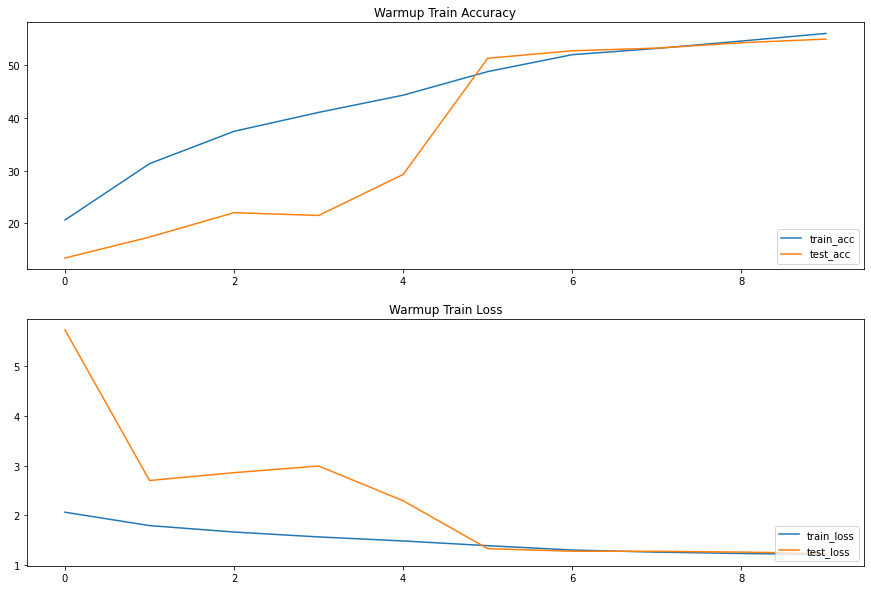

In [11]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Warmup Train Accuracy')
axs[0].plot(training_accuracy,label='train_acc')
axs[0].plot(warmup_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Warmup Train Loss')
axs[1].plot(training_loss,label='train_loss')
axs[1].plot(warmup_loss,label='test_loss')
axs[1].legend(loc='lower right')

### Generate `Pseudo-label` for all Unlabeled Data

In [12]:
# create psuedo-label for ulb data
def label(model):
    psuedolb = []
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    return psuedolb

In [16]:
#create psusedo-lbl using trained model
chkpoint_dir = '../outputs/trained_model/ssl_bd_250/checkpoint_warmup_train.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

psuedolb = label(model)

print("Outputs count: ",len(psuedolb))
# df['Psuedo-lb'] = psuedolb

for idx, img_idx in enumerate(unlabelled_idx):
    train_dataset.targets[img_idx] = psuedolb[idx]

print("Created psuedo-label for ulb data")

Outputs count:  45000
Created psuedo-label for ulb data


In [17]:
num_epochs = 200
epoch_ratio = 0.08
ulb_train_acc, ulb_train_loss = [], []
test_acc, test_loss = [], []

# reset learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 40, gamma = 0.1)

def shuffle_ulb():
    ulb_batch_idx = []

    # select from ulb_idx
    ulb_batch_idx = random.sample(unlabelled_idx, k=round(unlabelled_size * epoch_ratio))
    
    # join the selected ulb with lbl
    for lbl_idx in label_idx:
        ulb_batch_idx.append(lbl_idx)

    epoch_dataset = Subset(train_dataset, ulb_batch_idx)

    epoch_loader = DataLoader(
        epoch_dataset, batch_size=16,shuffle=True,
        num_workers=4, pin_memory=True,
    )

    return epoch_loader, ulb_batch_idx


def generate_psuedolbl(model, epoch):
    psuedolb = []
    # predict new psuedo-lbl for ulb dataset
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    
    # update label of all ulb data
    # df['Psuedo-lb'] = psuedolb    
    for idx, img_idx in enumerate(unlabelled_idx):
        train_dataset.targets[img_idx] = psuedolb[idx]

    # print("Created new psuedo-lbl for ulb dataset")

def get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    test_loss.append(epoch_loss)
    test_acc.append(test_epoch_acc)

    return test_epoch_acc

def ulb_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # save model
    # final_acc = current_corrects / unlabelled_size * 100
    # ulb_train_acc.append(final_acc)
    epoch_losses =  current_loss / label_size
    training_loss.append(epoch_losses)

    if (current_epoch+1) % 20 == 0:
        torch.save({ 
            'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(), 
            }, os.path.join(save_path, 'ulb_train_checkpoint_epoch_' + str(current_epoch+1)+'.pth'))

### `Iterative training`

In [18]:
# ground truth dataset to validate error
gt_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

#convert into for loop eventually
print("New batch size(including lbl): ", label_size+round(unlabelled_size * epoch_ratio))

############### Start of main ulb training ######################
for current_epochs in range(num_epochs):
    train_correct = 0
    test_correct = 0
    psuedolb = []

    # handle model
    if current_epochs == 0:
        # load model trained with lbl data (warmup)
        model_dir = chkpoint_dir
        checkpoint = torch.load(model_dir)
        model.load_state_dict(checkpoint["model_state_dict"])
    
    # Shuffle ulb_idx for new train
    epoch_loader, ulb_batch_idx = shuffle_ulb()

    # Re-train the model
    ulb_train(current_epoch=current_epochs, num_epoch=num_epochs, model=model, loader=epoch_loader)
    
    # Generate new label (Save to train_dataset)
    generate_psuedolbl(model, current_epochs)
    
    # Get epoch_acc
    for idx in unlabelled_idx:
        # get train acc
        if train_dataset.targets[idx] == gt_dataset.targets[idx]:
            train_correct += 1

    final_acc = train_correct / unlabelled_size * 100
    ulb_train_acc.append(final_acc)
    
    # Get test_acc
    curr_test_acc = get_test_acc(model)

    print("Current Epoch:", current_epochs, " Train Acc:", final_acc, " Test Acc:", curr_test_acc)

New batch size(including lbl):  8600


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 0  Train Acc: 48.102222222222224  Test Acc: 49.41


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 1  Train Acc: 48.30444444444444  Test Acc: 50.849999999999994


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 2  Train Acc: 56.64888888888889  Test Acc: 58.120000000000005


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 3  Train Acc: 59.599999999999994  Test Acc: 60.040000000000006


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 4  Train Acc: 57.782222222222224  Test Acc: 58.95


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 5  Train Acc: 61.531111111111116  Test Acc: 62.92


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 6  Train Acc: 60.148888888888884  Test Acc: 61.260000000000005


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 7  Train Acc: 68.68444444444445  Test Acc: 69.83


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 8  Train Acc: 66.24666666666667  Test Acc: 66.88


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 9  Train Acc: 70.28222222222223  Test Acc: 71.91


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 10  Train Acc: 73.04  Test Acc: 73.16


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 11  Train Acc: 71.35333333333334  Test Acc: 72.19


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 12  Train Acc: 69.78444444444445  Test Acc: 69.16


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 13  Train Acc: 72.97333333333333  Test Acc: 73.02


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 14  Train Acc: 73.69111111111111  Test Acc: 74.46000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 15  Train Acc: 74.71555555555555  Test Acc: 75.07000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 16  Train Acc: 74.71333333333334  Test Acc: 75.17


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 17  Train Acc: 74.46666666666667  Test Acc: 75.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 18  Train Acc: 74.09555555555556  Test Acc: 74.71


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 19  Train Acc: 76.51555555555557  Test Acc: 77.03999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 20  Train Acc: 77.08444444444444  Test Acc: 76.66


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 21  Train Acc: 77.60666666666667  Test Acc: 77.42999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 22  Train Acc: 75.67555555555555  Test Acc: 75.89


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 23  Train Acc: 78.68666666666667  Test Acc: 78.79


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 24  Train Acc: 77.72666666666666  Test Acc: 77.81


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 25  Train Acc: 76.82444444444444  Test Acc: 76.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 26  Train Acc: 77.22888888888889  Test Acc: 76.88000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 27  Train Acc: 78.0311111111111  Test Acc: 78.03


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 28  Train Acc: 78.92222222222223  Test Acc: 78.99000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 29  Train Acc: 79.37111111111112  Test Acc: 79.36999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 30  Train Acc: 79.31555555555555  Test Acc: 78.97999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 31  Train Acc: 78.66888888888889  Test Acc: 78.61


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 32  Train Acc: 79.55333333333333  Test Acc: 79.44


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 33  Train Acc: 78.66222222222223  Test Acc: 78.35


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 34  Train Acc: 79.7911111111111  Test Acc: 79.82000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 35  Train Acc: 78.60888888888888  Test Acc: 78.55


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 36  Train Acc: 77.93555555555555  Test Acc: 77.57


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 37  Train Acc: 80.71555555555555  Test Acc: 80.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 38  Train Acc: 79.64  Test Acc: 78.59


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 39  Train Acc: 80.72444444444444  Test Acc: 80.34


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 40  Train Acc: 81.84  Test Acc: 81.0


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 41  Train Acc: 80.13111111111111  Test Acc: 78.5


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 42  Train Acc: 80.31333333333333  Test Acc: 79.36


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 43  Train Acc: 81.92666666666668  Test Acc: 81.33


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 44  Train Acc: 80.44444444444444  Test Acc: 79.67


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 45  Train Acc: 81.84222222222223  Test Acc: 80.62


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 46  Train Acc: 80.38888888888889  Test Acc: 78.96


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 47  Train Acc: 80.88222222222223  Test Acc: 79.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 48  Train Acc: 81.16666666666667  Test Acc: 79.23


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 49  Train Acc: 80.78888888888889  Test Acc: 79.71000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 50  Train Acc: 82.56  Test Acc: 81.04


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 51  Train Acc: 81.50444444444445  Test Acc: 80.22


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 52  Train Acc: 81.21333333333334  Test Acc: 80.19


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 53  Train Acc: 81.46666666666667  Test Acc: 80.43


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 54  Train Acc: 82.50666666666666  Test Acc: 81.06


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 55  Train Acc: 81.72444444444444  Test Acc: 81.12


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 56  Train Acc: 83.12888888888888  Test Acc: 81.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 57  Train Acc: 82.36444444444444  Test Acc: 81.13


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 58  Train Acc: 83.07111111111111  Test Acc: 82.04


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 59  Train Acc: 82.36  Test Acc: 81.26


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 60  Train Acc: 82.55555555555556  Test Acc: 81.44


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 61  Train Acc: 82.87333333333333  Test Acc: 81.39999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 62  Train Acc: 83.73555555555555  Test Acc: 82.56


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 63  Train Acc: 83.34222222222222  Test Acc: 81.3


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 64  Train Acc: 82.4888888888889  Test Acc: 81.23


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 65  Train Acc: 83.64666666666668  Test Acc: 81.71000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 66  Train Acc: 83.19555555555556  Test Acc: 81.6


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 67  Train Acc: 84.10666666666667  Test Acc: 82.73


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 68  Train Acc: 84.16888888888889  Test Acc: 83.1


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 69  Train Acc: 82.47777777777779  Test Acc: 80.58


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 70  Train Acc: 83.83111111111111  Test Acc: 82.56


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 71  Train Acc: 84.50666666666666  Test Acc: 82.96


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 72  Train Acc: 84.34444444444445  Test Acc: 82.56


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 73  Train Acc: 83.01111111111112  Test Acc: 81.25


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 74  Train Acc: 83.85333333333334  Test Acc: 82.95


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 75  Train Acc: 83.26666666666667  Test Acc: 82.3


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 76  Train Acc: 84.11777777777777  Test Acc: 82.12


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 77  Train Acc: 83.03111111111112  Test Acc: 81.49


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 78  Train Acc: 83.71111111111111  Test Acc: 81.38


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 79  Train Acc: 84.98666666666666  Test Acc: 82.69


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 80  Train Acc: 84.65777777777778  Test Acc: 83.11


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 81  Train Acc: 84.9688888888889  Test Acc: 83.23


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 82  Train Acc: 84.17333333333333  Test Acc: 82.25


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 83  Train Acc: 85.10666666666667  Test Acc: 82.69


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 84  Train Acc: 84.99333333333333  Test Acc: 82.61


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 85  Train Acc: 83.66666666666667  Test Acc: 81.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 86  Train Acc: 85.94222222222221  Test Acc: 83.33


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 87  Train Acc: 85.9088888888889  Test Acc: 83.00999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 88  Train Acc: 84.83777777777777  Test Acc: 82.99


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 89  Train Acc: 85.08444444444444  Test Acc: 82.87


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 90  Train Acc: 85.16444444444444  Test Acc: 83.69


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 91  Train Acc: 85.96888888888888  Test Acc: 83.85000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 92  Train Acc: 85.17333333333333  Test Acc: 82.52000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 93  Train Acc: 85.42444444444445  Test Acc: 82.53


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 94  Train Acc: 86.16222222222221  Test Acc: 83.33


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 95  Train Acc: 85.93111111111111  Test Acc: 83.12


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 96  Train Acc: 85.2088888888889  Test Acc: 82.57


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 97  Train Acc: 84.87777777777778  Test Acc: 82.21000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 98  Train Acc: 85.09777777777778  Test Acc: 82.91


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 99  Train Acc: 86.13333333333333  Test Acc: 83.48


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 100  Train Acc: 86.06444444444445  Test Acc: 83.36


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 101  Train Acc: 86.67777777777778  Test Acc: 84.3


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 102  Train Acc: 85.45777777777778  Test Acc: 82.78


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 103  Train Acc: 86.17555555555556  Test Acc: 83.47


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 104  Train Acc: 86.26444444444445  Test Acc: 84.37


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 105  Train Acc: 85.77333333333334  Test Acc: 83.28999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 106  Train Acc: 86.24000000000001  Test Acc: 83.74000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 107  Train Acc: 85.78222222222223  Test Acc: 83.50999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 108  Train Acc: 86.8  Test Acc: 84.61999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 109  Train Acc: 86.11333333333333  Test Acc: 83.6


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 110  Train Acc: 84.9888888888889  Test Acc: 82.76


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 111  Train Acc: 87.10666666666667  Test Acc: 84.21


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 112  Train Acc: 86.21555555555555  Test Acc: 84.00999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 113  Train Acc: 84.41111111111111  Test Acc: 82.56


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 114  Train Acc: 86.89333333333333  Test Acc: 84.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 115  Train Acc: 85.97111111111111  Test Acc: 82.91


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 116  Train Acc: 86.84222222222222  Test Acc: 84.65


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 117  Train Acc: 86.65555555555555  Test Acc: 83.75


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 118  Train Acc: 86.7  Test Acc: 83.57


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 119  Train Acc: 86.29555555555555  Test Acc: 83.67999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 120  Train Acc: 86.80888888888889  Test Acc: 84.38


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 121  Train Acc: 87.67333333333333  Test Acc: 85.11999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 122  Train Acc: 86.33999999999999  Test Acc: 83.39999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 123  Train Acc: 87.70666666666666  Test Acc: 85.21


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 124  Train Acc: 85.4688888888889  Test Acc: 83.25


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 125  Train Acc: 87.74444444444444  Test Acc: 84.61


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 126  Train Acc: 86.97111111111111  Test Acc: 84.21


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 127  Train Acc: 87.05777777777777  Test Acc: 83.71


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 128  Train Acc: 87.28666666666666  Test Acc: 84.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 129  Train Acc: 87.74888888888889  Test Acc: 84.52


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 130  Train Acc: 87.74888888888889  Test Acc: 85.41


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 131  Train Acc: 87.20222222222222  Test Acc: 84.50999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 132  Train Acc: 87.04888888888888  Test Acc: 84.7


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 133  Train Acc: 87.64888888888889  Test Acc: 85.09


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 134  Train Acc: 88.31777777777778  Test Acc: 85.14


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 135  Train Acc: 88.05111111111111  Test Acc: 85.52


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 136  Train Acc: 88.4088888888889  Test Acc: 85.19


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 137  Train Acc: 88.00666666666666  Test Acc: 84.76


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 138  Train Acc: 87.89333333333333  Test Acc: 84.61999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 139  Train Acc: 88.01333333333334  Test Acc: 85.09


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 140  Train Acc: 88.0111111111111  Test Acc: 84.84


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 141  Train Acc: 88.25777777777778  Test Acc: 85.2


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 142  Train Acc: 87.43777777777778  Test Acc: 84.46000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 143  Train Acc: 88.50222222222223  Test Acc: 85.59


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 144  Train Acc: 87.8  Test Acc: 84.67


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 145  Train Acc: 87.88666666666667  Test Acc: 84.89999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 146  Train Acc: 87.79777777777778  Test Acc: 85.42


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 147  Train Acc: 87.99555555555555  Test Acc: 84.83000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 148  Train Acc: 88.73111111111112  Test Acc: 85.63


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 149  Train Acc: 87.84444444444445  Test Acc: 84.7


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 150  Train Acc: 88.52222222222223  Test Acc: 85.76


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 151  Train Acc: 87.77777777777777  Test Acc: 84.73


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 152  Train Acc: 88.12444444444445  Test Acc: 84.96000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 153  Train Acc: 88.50444444444445  Test Acc: 84.93


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 154  Train Acc: 88.75555555555556  Test Acc: 85.3


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 155  Train Acc: 88.1  Test Acc: 85.05


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 156  Train Acc: 89.04666666666667  Test Acc: 85.25


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 157  Train Acc: 88.15777777777778  Test Acc: 84.58


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 158  Train Acc: 89.30666666666667  Test Acc: 86.2


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 159  Train Acc: 88.76444444444445  Test Acc: 85.37


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 160  Train Acc: 89.58  Test Acc: 85.95


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 161  Train Acc: 88.26444444444445  Test Acc: 84.78999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 162  Train Acc: 88.63777777777779  Test Acc: 84.87


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 163  Train Acc: 89.26222222222222  Test Acc: 85.75


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 164  Train Acc: 88.75555555555556  Test Acc: 85.7


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 165  Train Acc: 87.38222222222221  Test Acc: 83.53


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 166  Train Acc: 88.53333333333333  Test Acc: 85.61999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 167  Train Acc: 89.14  Test Acc: 86.33999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 168  Train Acc: 89.23111111111112  Test Acc: 85.71


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 169  Train Acc: 88.58666666666667  Test Acc: 85.27


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 170  Train Acc: 89.42444444444445  Test Acc: 86.1


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 171  Train Acc: 89.11333333333333  Test Acc: 86.11


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 172  Train Acc: 89.63333333333333  Test Acc: 86.59


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 173  Train Acc: 89.13555555555556  Test Acc: 85.72999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 174  Train Acc: 88.63777777777779  Test Acc: 85.55


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 175  Train Acc: 87.98666666666666  Test Acc: 84.54


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 176  Train Acc: 88.34  Test Acc: 85.14


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 177  Train Acc: 89.02  Test Acc: 85.77


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 178  Train Acc: 88.8  Test Acc: 85.78


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 179  Train Acc: 89.32222222222222  Test Acc: 85.79


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 180  Train Acc: 89.78888888888889  Test Acc: 85.85000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 181  Train Acc: 89.22444444444444  Test Acc: 85.22


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 182  Train Acc: 89.89333333333333  Test Acc: 86.21


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 183  Train Acc: 89.60000000000001  Test Acc: 86.19


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 184  Train Acc: 89.69777777777777  Test Acc: 85.78


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 185  Train Acc: 88.46888888888888  Test Acc: 85.44


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 186  Train Acc: 89.11777777777777  Test Acc: 85.21


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 187  Train Acc: 89.92444444444445  Test Acc: 86.29


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 188  Train Acc: 89.36  Test Acc: 85.75


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 189  Train Acc: 90.30666666666667  Test Acc: 86.48


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 190  Train Acc: 89.39111111111112  Test Acc: 85.95


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 191  Train Acc: 89.17111111111112  Test Acc: 85.75


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 192  Train Acc: 88.02222222222223  Test Acc: 84.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 193  Train Acc: 88.97555555555556  Test Acc: 84.99


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 194  Train Acc: 89.39111111111112  Test Acc: 85.61999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 195  Train Acc: 89.58444444444444  Test Acc: 85.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 196  Train Acc: 89.92222222222223  Test Acc: 86.06


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 197  Train Acc: 89.30444444444444  Test Acc: 85.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 198  Train Acc: 90.10444444444444  Test Acc: 85.82


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 199  Train Acc: 90.08222222222221  Test Acc: 85.91


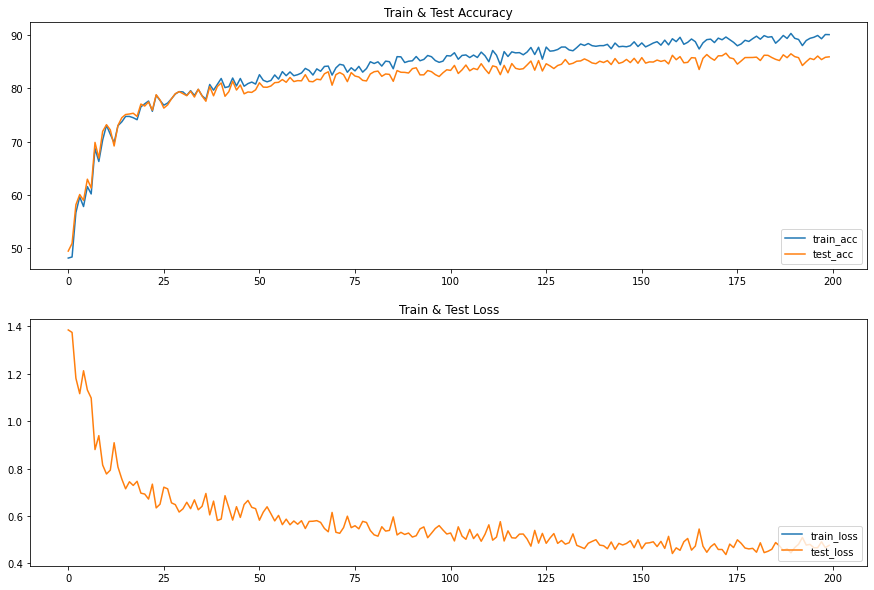

In [19]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Train & Test Accuracy')
axs[0].plot(ulb_train_acc,label='train_acc')
axs[0].plot(test_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Train & Test Loss')
axs[1].plot(ulb_train_loss,label='train_loss')
axs[1].plot(test_loss,label='test_loss')
axs[1].legend(loc='lower right')

In [20]:
top1_acc = max(test_acc)
best_model_state = test_acc.index(top1_acc)
top1_loss = test_loss[best_model_state]

#get train acc at that state
top1_train_acc = ulb_train_acc[best_model_state]

print("Top-1 Test Acc: ", top1_acc)
print("Loss: ", top1_loss)
print("Corresponding train acc: ", top1_train_acc)
print("Best model state: ", best_model_state)

Top-1 Test Acc:  86.59
Loss:  0.43753157877922055
Corresponding train acc:  89.63333333333333
Best model state:  172


### Calculate Attack Success Rate - `ASR`

In [21]:
bd_test_dir = '../inputs/bd-cifar_test/deer/*.png'
all_images = glob.glob(bd_test_dir)
bd_pred = []

# load best model state
chkpoint_dir = '../outputs/trained_model/ssl_bd_250/ulb_train_checkpoint_epoch_180.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

model.eval()

transform = A.Compose([
    A.Resize(32, 32),
    A.Normalize(
    mean = [0.3403, 0.3121, 0.3214],
    std = [0.2724, 0.2608, 0.2669]
    ),
    ToTensorV2(),
    ])

for i, image_path in enumerate(all_images):
    image = cv2.imread(image_path)
    orig_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = orig_image.shape

     # Apply the image transforms.
    image_tensor = transform(image=image)['image']
    # Add batch dimension.
    image_tensor = image_tensor.unsqueeze(0)
    # Forward pass through model.
    outputs = model(image_tensor.to(device))
    # Get the softmax probabilities.
    probs = F.softmax(outputs).data.squeeze()
    # Get the class indices of top k probabilities.
    class_idx = topk(probs, 1)[1].int()
    # Get the ground truth.
    image_name = image_path.split(os.path.sep)[-1]
    bd_pred.append(class_idx.item())

C:\Users\65913\AppData\Local\Temp\ipykernel_14732\4118399366.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


In [22]:
# print(bd_pred)
atk_count = 0

for im in bd_pred:
    if im == 4:
        atk_count += 1

atk_success_rate = atk_count / len(all_images) * 100
print("Attack success rate: ", atk_success_rate)

Attack success rate:  95.0
